# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
from itertools import product
parameters = dict(
    lr = [.01, .001, .0001],
    batch_size = [16, 32, 64],
    shuffle = [True, False])
param_values = [v for v in parameters.values()]
for lr, bz, shuffle in product(*param_values):
    print(lr,bz,shuffle)

0.01 16 True
0.01 16 False
0.01 32 True
0.01 32 False
0.01 64 True
0.01 64 False
0.001 16 True
0.001 16 False
0.001 32 True
0.001 32 False
0.001 64 True
0.001 64 False
0.0001 16 True
0.0001 16 False
0.0001 32 True
0.0001 32 False
0.0001 64 True
0.0001 64 False


In [7]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z) # (100, 1, 28, 28)
    result = y_hat.view(100, 28, 28).cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img, y_hat

In [9]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [10]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [11]:
n_noise = 100

In [12]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [14]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [15]:
batch_size = 64

In [16]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [17]:
image, _ = next(iter(data_loader))
grid = torchvision.utils.make_grid(image)
comment = f'batch_size={batch_size} n_noise={n_noise} lr=0.0002,0.0002 n_critic=2'
tb = SummaryWriter('runs/VanillaGAN', comment=comment)
tb.add_image('images',grid)
#tb.add_graph(D, image)

In [18]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [19]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 2 # for training more k steps about Discriminator

In [20]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [21]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [21]:
D_x_loss_full, D_z_loss_full, D_loss_full, G_loss_full = 0,0,0,0
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels) # true label loss
        D_x_loss_full += D_x_loss

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes) # fake label loss
        D_loss = D_x_loss + D_z_loss
        D_z_loss_full += D_z_loss
        D_loss_full += D_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)
            G_loss_full += G_loss

            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
            if step > 0:
                tb.add_scalars('losses', {
                    'D_x_loss': D_x_loss_full/500,
                    'D_z_loss': D_z_loss_full/500,
                    'D_loss': D_loss_full/500,
                    'G_loss': G_loss_full/500*n_critic
                }, step)
                tb.add_scalar('D_x_loss', D_x_loss_full/500, step)
                D_x_loss_full = 0
                tb.add_scalar('D_z_loss', D_z_loss_full/500, step)
                D_z_loss_full = 0
                tb.add_scalar('D_loss', D_loss_full/500, step)
                D_loss_full = 0
                tb.add_scalar('G_loss', G_loss_full/500*n_critic, step)
                G_loss_full = 0
            else:
                tb.add_scalars('losses', {
                    'D_x_loss': D_x_loss_full,
                    'D_z_loss': D_z_loss_full,
                    'D_loss': D_loss_full,
                    'G_loss': G_loss_full
                }, step)
                tb.add_scalar('D_x_loss', D_x_loss_full, step)
                tb.add_scalar('D_z_loss', D_z_loss_full, step)
                tb.add_scalar('D_loss', D_loss_full, step)
                tb.add_scalar('G_loss', G_loss_full, step)
        
        if step % 1000 == 0:
            G.eval()
            img, y_hat = get_sample_image(G, n_noise)
            grid = torchvision.utils.make_grid(y_hat)
            tb.add_image(f'step_{step}', grid)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1
        
        for name, weight in D.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f'{name}.grad', weight.grad, epoch)

Epoch: 0/50, Step: 0, D Loss: 1.38594651222229, G Loss: 0.6885676980018616
Epoch: 0/50, Step: 500, D Loss: 0.9828395843505859, G Loss: 0.9116342663764954
Epoch: 1/50, Step: 1000, D Loss: 1.065786361694336, G Loss: 0.8011631965637207
Epoch: 1/50, Step: 1500, D Loss: 1.150916337966919, G Loss: 0.7736944556236267
Epoch: 2/50, Step: 2000, D Loss: 1.0341540575027466, G Loss: 0.8259260058403015
Epoch: 2/50, Step: 2500, D Loss: 0.9175624251365662, G Loss: 1.037489414215088
Epoch: 3/50, Step: 3000, D Loss: 0.8965947031974792, G Loss: 1.2028768062591553
Epoch: 3/50, Step: 3500, D Loss: 0.8543988466262817, G Loss: 1.2055662870407104
Epoch: 4/50, Step: 4000, D Loss: 0.9283633232116699, G Loss: 0.8935650587081909
Epoch: 4/50, Step: 4500, D Loss: 0.9084739685058594, G Loss: 1.2687623500823975
Epoch: 5/50, Step: 5000, D Loss: 1.1129279136657715, G Loss: 0.7015480399131775
Epoch: 5/50, Step: 5500, D Loss: 1.034576654434204, G Loss: 1.1303168535232544
Epoch: 6/50, Step: 6000, D Loss: 1.18826162815094,

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/harvey/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-05a54b441547>", line 72, in <module>
    tb.add_histogram(f'{name}.grad', weight.grad, epoch)
  File "/Users/harvey/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/tensorboard/writer.py", line 425, in add_histogram
    histogram(tag, values, bins, max_bins=max_bins), global_step, walltime)
  File "/Users/harvey/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/tensorboard/summary.py", line 234, in histogram
    hist = make_histogram(values.astype(float), bins, max_bins)
  File "/Users/harvey/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/utils/tensorboard/summary.py", line 243, in make_histogram
    counts, limits = np.histogram(values, bins=bins)
  File "<__array_function__ internals>", line 6, in histogra

TypeError: object of type 'NoneType' has no len()

## Visualize Sample

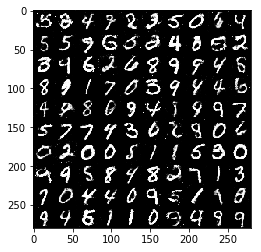

In [20]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [14]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')